In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display

from dual_data_utils import make_clean_concat_data
from stopsignalmetrics import StopData, SSRTmodel

# Read in and Compute Metrics on Data

In [2]:
dataset='validation'

In [3]:
OUTLIER_THRESH  = 3
SSD_THRESH = 200

dual_dict = {
    'stop_signal_with_cued_task_switching': {
        'dual_col': 'cue_task_switch',
        'DC': 'cue_stay_task_stay',
        'DE': 'cue_switch_task_switch',
        'OTHER': ['cue_switch_task_stay']
    },
    'stop_signal_with_directed_forgetting': {
        'dual_col': 'directed_forgetting_condition',
        'DC': 'con',
        'DE': 'neg',
        'OTHER': ['pos']
    },
    'stop_signal_with_flanker': {
        'dual_col': 'flanker_condition',
        'DC': 'congruent',
        'DE': 'incongruent'
    },
    'stop_signal_with_go_no_go': {
        'dual_col': 'go_nogo_condition',
        'DC': 'go',
        'DE': 'nogo'
    },
    'stop_signal_with_n_back': {
        'dual_col': 'delay_condition',
        'DC': 1.,
        'DE': 2.,
        'OTHER': [3.]
    },
    'stop_signal_with_predictable_task_switching': {
        'dual_col': 'predictable_condition',
        'DC': 'stay',
        'DE': 'switch'
    },
    'stop_signal_with_shape_matching': {
        'dual_col': 'shape_matching_condition',
        'DC': 'CONTROL',
        'DE': 'DISTRACTOR',
        'OTHER': ['DSD', 'SSS']
    },
}

stopmetrics_var_dict = {
    'columns': {
        'ID': 'worker_id',
        'block': 'current_block',
        'condition': 'SS_trial_type',
        'SSD': 'SS_delay',
        'goRT': 'rt',
        'stopRT': 'rt',
        'response': 'key_press',
        'correct_response': 'choice_correct_response',
        'choice_accuracy': 'choice_accuracy'},
    'key_codes': {
        'go': 'go',
        'stop': 'stop',
        'correct': 1,
        'incorrect': 0,
        'noResponse': -1}}

In [4]:
def get_query_str(col, condition):
    if type(condition)==str:
        return "%s=='%s'" % (col, condition)
    elif type(condition) in [float, int]:
        return "%s==%s" % (col, condition)
    elif type(condition)==list:
        return "%s in %s" % (col, condition)

def stop_summarize(curr_data, thresh=SSD_THRESH, query_str=None):
    data_df = curr_data.query(query_str) if query_str is not None else curr_data
    
    sum_df = SSRTmodel().fit_transform(data_df, level='group')
    sum_df_threshSSDs = SSRTmodel().fit_transform(data_df.query(f'SSD>={thresh} or condition=="go"'), level='group').add_suffix('_wThresh_SSDs')
    sum_df_threshSubs = sum_df.query(f"mean_SSD >= {thresh}").add_suffix('_wThresh_subs')
    return pd.concat([sum_df, sum_df_threshSSDs, sum_df_threshSubs],
                       1,
                       sort=True
                      )

def get_inhib_func(curr_data, cond):
    inhib_df = pd.DataFrame(curr_data.groupby(['ID', 'SSD']).apply(lambda x: x.stopRT.notnull().sum()/len(x))).reset_index()
    inhib_df['condition'] = cond
    return inhib_df

def get_gng_presp(curr_data):
    curr_data = curr_data.copy()
    stop_trials = curr_data.query("stop_signal_condition=='stop'")
    out={}
    out['p_resp'] = (stop_trials.rt != -1).sum()/len(stop_trials)
    out['p_resp_go'] = (stop_trials.query("go_nogo_condition=='go'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='go'"))
    out['p_resp_nogo'] = (stop_trials.query("go_nogo_condition=='nogo'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='nogo'"))
    return out

In [5]:
stop_data_dict = make_clean_concat_data(stop_subset=True, dataset=dataset)

# Check P(resp|signal) in Go/NoGo 

In [6]:
gng_presp_data = pd.DataFrame(list(stop_data_dict['stop_signal_with_go_no_go'].groupby('worker_id').apply(get_gng_presp)))
gng_presp_data.describe()

,p_resp,p_resp_go,p_resp_nogo
count,33.000000,33.000000,33.000000
mean,0.433333,0.501768,0.022727
std,0.017097,0.016765,0.058751
min,0.371429,0.433333,0.000000
25%,0.428571,0.500000,0.000000
50%,0.435714,0.500000,0.000000
75%,0.442857,0.508333,0.000000
max,0.471429,0.525000,0.300000


In [7]:
del stop_data_dict['stop_signal_with_go_no_go']

# Get SSRT metrics for remaining tasks

In [8]:
# build dict
ssrtc_out = {}
for task_name in stop_data_dict.keys():  # [k for k in stop_data_dict.keys()][:1]:  # development loop using just 1st task
    curr_data = StopData(stopmetrics_var_dict).fit_transform(stop_data_dict[task_name].drop(columns=['correct_response']))
    short_name = task_name.split('_with_')[-1]
    ssrtc_out[short_name] = stop_summarize(curr_data)
    
    if 'with' in task_name:
        dual_col = dual_dict[task_name]['dual_col']
        for key in [k for k in dual_dict[task_name] if k!='dual_col']:
            query_str = get_query_str(dual_col, dual_dict[task_name][key])
            ssrtc_out['%s_%s' % (short_name,key)] = stop_summarize(
                curr_data,
                query_str=query_str
            )

ssrtc_out['SE'] = ssrtc_out.pop('stop_signal_single_task_network')
metrics = [c for c in ssrtc_out['SE'].columns if 'max_RT' not in c]

#flatten data, remove outliers w/ values > 3 SDs from the mean
flattened_data = pd.concat([ssrtc_out[k].add_prefix(k+'_') for k in ssrtc_out], axis=1, sort=True)
flattened_data = flattened_data.filter(regex='SE|DC|DE', axis=1)
z_df = flattened_data.apply(stats.zscore).apply(np.abs)
flattened_data[z_df>OUTLIER_THRESH] = None
flattened_data.index.name='ID'



SSRTs = flattened_data.loc[:, ~flattened_data.columns.str.contains("wThresh")].filter(regex='SSRT')
SSRTs_ThreshSSDs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_SSDs")].filter(regex='SSRT')
SSRTs_ThreshSubs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_subs")].filter(regex='SSRT')

# Validation Analyses

In [9]:
old_nSubs = len(SSRTs)
SSRTs = SSRTs.dropna()
new_nSubs = len(SSRTs)
print(f'{old_nSubs-new_nSubs} subs dropped for nan cell')

2 subs dropped for nan cell


# One-way Anova

In [10]:
SSRTs_taskMeaned = pd.DataFrame()
for task_name in stop_data_dict.keys():
    short_name = task_name.split('_with_')[-1]
    if short_name == 'stop_signal_single_task_network':
        SSRTs_taskMeaned['SE'] = SSRTs.filter(regex='SE')
    else:
        SSRTs_taskMeaned[short_name] = SSRTs.filter(regex=short_name).mean(1)
SSRTs_taskMeaned.head()

,cued_task_switching,SE,directed_forgetting,flanker,predictable_task_switching,n_back,shape_matching
ID,,,,,,,
s009,168.00,193.916667,296.0,208.25,221.75,248.219758,219.333333
s019,257.00,233.666667,366.0,243.75,261.00,197.663734,294.833333
s031,349.50,237.000000,322.5,292.00,292.75,273.458333,261.583333
s034,233.75,198.500000,390.5,258.00,254.00,320.218750,264.083333
s038,223.75,206.750000,309.5,223.50,194.00,253.545363,223.916667


In [11]:
melted_SSRTs = SSRTs_taskMeaned.reset_index().melt(id_vars='ID')
melted_SSRTs

,ID,variable,value
0,s009,cued_task_switching,168.000000
1,s019,cued_task_switching,257.000000
2,s031,cued_task_switching,349.500000
3,s034,cued_task_switching,233.750000
4,s038,cued_task_switching,223.750000
...,...,...,...
212,s514,shape_matching,296.833333
213,s528,shape_matching,288.666667
214,s541,shape_matching,198.500000
215,s548,shape_matching,305.416667


In [12]:
anova_res = pg.rm_anova(data=melted_SSRTs, dv='value', within='variable', subject='ID', detailed=True)
anova_res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,288913.843232,6,48152.307205,34.753595,1.039136e-27,3.682862e-19,0.536705,0.662985,False,0.178864,0.000482
1,Error,249396.223688,180,1385.534576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Planned Contrasts

Guidelines from [here](http://web.pdx.edu/~newsomj/uvclass/ho_planned%20contrasts.pdf)

In [13]:
df = anova_res.loc[anova_res.Source=='Error', 'DF'].values[0]

In [14]:
MS = anova_res.loc[anova_res.Source=='Error', 'MS'].values[0]
std_err = np.sqrt(MS * (2/len(SSRTs)))
std_err

9.454592930776158

In [15]:
for task in ['directed_forgetting', 'n_back', 'cued_task_switching', 'shape_matching']:
    diff = np.mean(SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex='SE').values)
    t = diff/std_err
    pval = stats.t.sf(t, df) 
    print(f'{task}: Mean={diff:.2f}, t={t:.3f}, p={pval:.6f}, d={diff/ np.std(SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex="SE").values):.2f}')

directed_forgetting: Mean=113.67, t=12.023, p=0.000000, d=1.84
n_back: Mean=35.91, t=3.798, p=0.000100, d=0.57
cued_task_switching: Mean=15.36, t=1.624, p=0.053041, d=0.30
shape_matching: Mean=34.85, t=3.686, p=0.000151, d=1.01


## Planned related-samples t-test for n-Back load

In [16]:
diff_SSRTs = SSRTs.sub(SSRTs.filter(regex='SE').values)
del diff_SSRTs['SE_SSRT']

In [17]:
t, pval = stats.ttest_rel(diff_SSRTs.n_back_DE_SSRT.values, diff_SSRTs.n_back_DC_SSRT.values, nan_policy='raise', alternative='greater')
diff_vals = diff_SSRTs.n_back_DE_SSRT.values - diff_SSRTs.n_back_DC_SSRT.values
print(f'n-Back DE > DC: Mean={np.mean(diff_vals):.2f}, t={t:.3f}, p={pval:.6f}, d={np.mean(diff_vals)/np.std(diff_vals):.2}')

n-Back DE > DC: Mean=26.16, t=2.277, p=0.015052, d=0.42


# Visualize

In [18]:
formal_tasks = {
    'All': 'All',
    'SE': 'Single Task',
    'single_task': 'Single Task',
    'go_no_go': 'Go/No-Go',
    'predictable_task_switching': 'Predictable Task Switching',
    'cued_task_switching': 'Cued Task Switching',
    'flanker': 'Flanker',
    'shape_matching': 'Shape Matching',
    'n_back': 'n-Back',
    'directed_forgetting': 'Directed Forgetting' 
}

In [19]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
palette ={"DC":"C0", "DE":"C1", "SE":"C2",
         "Dual Context":"C0", "Dual Condition":"C1", "Single":"C2"}

task_order_dict = {
    'SE': 'aa',
    'go_no_go': 'ab',
    'predictable_task_switching': 'ba',
    'cued_task_switching': 'bb',
    'flanker': 'ca',
    'shape_matching': 'cb',
    'n_back': 'da',
    'directed_forgetting': 'db'
}

trial_order_dict = {
    'Single': 'aa',
    'Dual Context': 'ab',
    'Dual Condition': 'ba',
}

def context_str(string):
    if 'DC' in string:
        return 'Dual Context'
    elif 'DE' in string:
        return 'Dual Condition'
    elif 'SE' in string:
        return 'Single'
    elif 'OTHER' in string:
        return 'POS/3BACK/DSD|SSS/CUE_SWITCH'
    else:
        return 'COMBINE'

In [20]:
melted_SSRTs = SSRTs.reset_index().melt(id_vars='ID', value_name='SSRT')
melted_SSRTs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_SSRTs['variable']]
melted_SSRTs['Trial Type'] = [context_str(i) for i in melted_SSRTs['variable']]

melted_SSRTs['task_order'] = melted_SSRTs['Task'].map(task_order_dict)
melted_SSRTs['trial_order'] = melted_SSRTs['Trial Type'].map(trial_order_dict)

melted_SSRTs = melted_SSRTs.sort_values(['task_order', 'trial_order'])
melted_SSRTs['Task'] = melted_SSRTs['Task'].map(formal_tasks)
melted_SSRTs

,ID,variable,SSRT,Task,Trial Type,task_order,trial_order
372,s009,SE_SSRT,193.916667,Single Task,Single,aa,aa
373,s019,SE_SSRT,233.666667,Single Task,Single,aa,aa
374,s031,SE_SSRT,237.000000,Single Task,Single,aa,aa
375,s034,SE_SSRT,198.500000,Single Task,Single,aa,aa
376,s038,SE_SSRT,206.750000,Single Task,Single,aa,aa
...,...,...,...,...,...,...,...
119,s514,directed_forgetting_DE_SSRT,258.000000,Directed Forgetting,Dual Condition,db,ba
120,s528,directed_forgetting_DE_SSRT,356.000000,Directed Forgetting,Dual Condition,db,ba
121,s541,directed_forgetting_DE_SSRT,369.500000,Directed Forgetting,Dual Condition,db,ba
122,s548,directed_forgetting_DE_SSRT,429.500000,Directed Forgetting,Dual Condition,db,ba


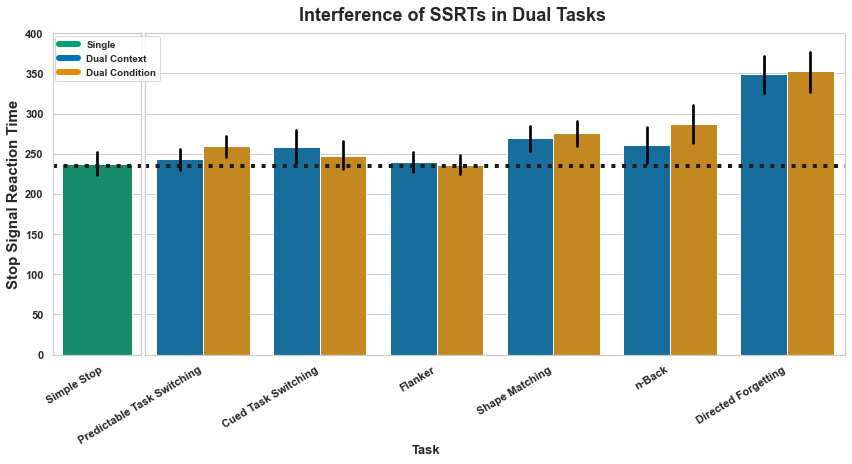

In [21]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 8]}, sharey=True, figsize=(12,6.5))

# Single Task
bar = sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Single'])], palette=palette, errcolor='0', ax=a0)
a0.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
a0.set_ylabel('Stop Signal Reaction Time', fontweight='bold', fontsize=15)
a0.set_xlabel('')
a0.set_xticks([-.25])
a0.set_xticklabels(['Simple Stop'], rotation=31, fontweight='bold', fontsize='11')
a0.set_yticks(np.arange(0, 450, 50))
a0.set_ylim([0, 400.5])
a0.set_yticklabels(np.arange(0, 450, 50), fontdict={'fontweight':'bold', 'fontsize':'11'})


custom_lines = [Line2D([0], [0], color=sns.color_palette()[2], lw=6),
                Line2D([0], [0], color=sns.color_palette()[0], lw=6),
                Line2D([0], [0], color=sns.color_palette()[1], lw=6)]
a0.set_zorder(1)
a0.legend(custom_lines, ['Single', 'Dual Context', 'Dual Condition'], prop={'weight': 'bold', 'size':9.75}, loc=(0.022,.85), frameon=True)


# Dual Tasks
sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Dual Context', 'Dual Condition'])], palette=palette, errcolor='0', ax=a1)
a1.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
a1.set_ylabel('')
a1.set_xlabel('')
a1.get_legend().remove()

# _ = plt.legend(prop={'weight': 'bold'})
_ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
_ = plt.yticks(fontweight='bold', fontsize='12')



_ = f.text(0.5, 0.01, 'Task', ha='center', fontweight='bold', fontsize=13)
_ = plt.title('Interference of SSRTs in Dual Tasks', fontsize='18', fontweight='bold',  y=1.1, x=.44, pad=-20)
f.tight_layout()
plt.subplots_adjust(wspace=.01)
plt.savefig(f'figures/dataset-{dataset}_metric-SSRT_barplot.png', dpi=300)
plt.show()
plt.close()

In [22]:
melted_diffs = diff_SSRTs.reset_index().melt(id_vars='ID', value_name='Dual Task SSRT - Single Task SSRT')
melted_diffs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_diffs['variable']]
melted_diffs['Trial Type'] = [context_str(i) for i in melted_diffs['variable']]

melted_diffs['task_order'] = melted_diffs['Task'].map(task_order_dict)
melted_diffs['trial_order'] = melted_diffs['Trial Type'].map(trial_order_dict)

melted_diffs = melted_diffs.sort_values(['task_order', 'trial_order'])
melted_diffs['Task'] = melted_diffs['Task'].map(formal_tasks)

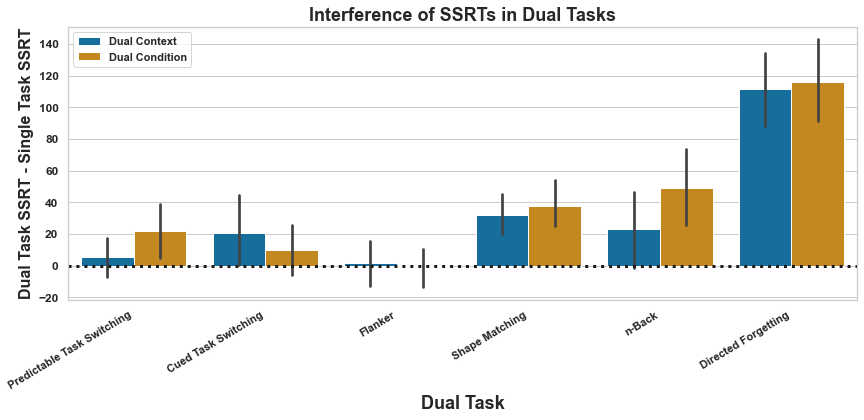

In [23]:
fig = plt.figure(figsize=(12,6))

bar = sns.barplot(x='Task', y='Dual Task SSRT - Single Task SSRT', hue='Trial Type', data=melted_diffs, palette=palette)
plt.legend(prop={'weight': 'bold'})

_ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
_ = plt.yticks(fontweight='bold', fontsize='12')

bar.set_xlabel('Dual Task', fontsize = 18, fontweight='bold')
bar.set_ylabel('Dual Task SSRT - Single Task SSRT', fontsize = 16, fontweight='bold')

lowx, highx = plt.xlim()
plt.plot([lowx, highx],[0,0],color='k',linestyle=':',linewidth=3)
plt.title('Interference of SSRTs in Dual Tasks', fontsize='18', fontweight='bold')
plt.tight_layout()
lowy, highy = plt.ylim()
_ = plt.axis([lowx, highx, lowy, highy])
plt.savefig(f'figures/dataset-{dataset}_metric-SSRT_differences_barplot.png', dpi=300)
plt.show()
plt.close()

# Repetitions with Exclusions

In [24]:
def pipeline(SSRTs, strip_str=''):
    SSRTs = SSRTs.copy()
    SSRTs.columns = [c.replace(strip_str, '') for c in SSRTs.columns]
    
    old_nSubs = len(SSRTs)
    SSRTs = SSRTs.dropna()
    new_nSubs = len(SSRTs)
    print(f'{old_nSubs-new_nSubs} subs dropped for nan cell')

    # One-way ANOVA
    SSRTs_taskMeaned = pd.DataFrame()
    for task_name in stop_data_dict.keys():
        short_name = task_name.split('_with_')[-1]
        if short_name == 'stop_signal_single_task_network':
            SSRTs_taskMeaned['SE'] = SSRTs.filter(regex='SE')
        else:
            SSRTs_taskMeaned[short_name] = SSRTs.filter(regex=short_name).mean(1)
    melted_SSRTs = SSRTs_taskMeaned.reset_index().melt(id_vars='ID')
    anova_res = pg.rm_anova(data=melted_SSRTs, dv='value', within='variable', subject='ID', detailed=True)
    display(anova_res)

    # Planned Contrasts
    planned_tasks = ['directed_forgetting', 'n_back', 'cued_task_switching', 'shape_matching']
    out_df = pd.DataFrame(index=planned_tasks + ['n_back: DE > DC'], columns=['mean', 't', 'p', 'd'])
    df = anova_res.loc[anova_res.Source=='Error', 'DF'].values[0]
    MS = anova_res.loc[anova_res.Source=='Error', 'MS'].values[0]
    std_err = np.sqrt(MS * (2/len(SSRTs)))
    for task in planned_tasks:
        diffs = (SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex='SE').values)
        t = np.mean(diffs)/std_err
        pval = stats.t.sf(t, df) 
        print(f'{task}: Mean={diff:.2f}, t={t:.3f}, p={pval:.6f}, d={np.mean(diffs)/np.std(diffs):.2f}')
        out_df.loc[task, ['mean', 't', 'p', 'd']] = np.mean(diffs), t, pval, np.mean(diffs)/np.std(diffs)

    # n-Back t-test
    diff_SSRTs = SSRTs.sub(SSRTs.filter(regex='SE').values)
    del diff_SSRTs['SE_SSRT']
    
    diffs = (diff_SSRTs.n_back_DE_SSRT.values - diff_SSRTs.n_back_DC_SSRT.values)
    t, pval = stats.ttest_rel(diff_SSRTs.n_back_DE_SSRT.values, diff_SSRTs.n_back_DC_SSRT.values, nan_policy='raise', alternative='greater')
    print(f'n-Back DE > DC: Mean={np.mean(diffs):.2f}, t={t:.3f}, p={pval:.6f}, d={np.mean(diffs)/np.std(diffs):.2f}')
    out_df.loc['n_back: DE > DC', ['mean', 't', 'p', 'd']] = np.mean(diffs), t, pval, np.mean(diffs)/np.std(diffs)

    # Visualization
    
    # All 7 tasks
    melted_SSRTs = SSRTs.reset_index().melt(id_vars='ID', value_name='SSRT')
    melted_SSRTs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_SSRTs['variable']]
    melted_SSRTs['Trial Type'] = [context_str(i) for i in melted_SSRTs['variable']]

    melted_SSRTs['task_order'] = melted_SSRTs['Task'].map(task_order_dict)
    melted_SSRTs['trial_order'] = melted_SSRTs['Trial Type'].map(trial_order_dict)

    melted_SSRTs = melted_SSRTs.sort_values(['task_order', 'trial_order'])
    melted_SSRTs['Task'] = melted_SSRTs['Task'].map(formal_tasks)

    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 8]}, sharey=True, figsize=(12,6.5))

    # Single Task
    bar = sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Single'])], palette=palette, errcolor='0', ax=a0)
    a0.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
    a0.set_ylabel('Stop Signal Reaction Time', fontweight='bold', fontsize=15)
    a0.set_xlabel('')
    a0.set_xticks([-.25])
    a0.set_xticklabels(['Simple Stop'], rotation=31, fontweight='bold', fontsize='11')
    a0.set_yticks(np.arange(0, 450, 50))
    a0.set_ylim([0, 400.5])
    a0.set_yticklabels(np.arange(0, 450, 50), fontdict={'fontweight':'bold', 'fontsize':'11'})


    custom_lines = [Line2D([0], [0], color=sns.color_palette()[2], lw=6),
                    Line2D([0], [0], color=sns.color_palette()[0], lw=6),
                    Line2D([0], [0], color=sns.color_palette()[1], lw=6)]
    a0.set_zorder(1)
    a0.legend(custom_lines, ['Single', 'Dual Context', 'Dual Condition'], prop={'weight': 'bold', 'size':9.75}, loc=(0.022,.85), frameon=True)


    # Dual Tasks
    sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Dual Context', 'Dual Condition'])], palette=palette, errcolor='0', ax=a1)
    a1.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
    a1.set_ylabel('')
    a1.set_xlabel('')
    a1.get_legend().remove()

    # _ = plt.legend(prop={'weight': 'bold'})
    _ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
    _ = plt.yticks(fontweight='bold', fontsize='12')



    _ = f.text(0.5, 0.01, 'Task', ha='center', fontweight='bold', fontsize=13)
    _ = plt.title('Interference of SSRTs in Dual Tasks', fontsize='18', fontweight='bold',  y=1.1, x=.44, pad=-20)
    f.tight_layout()
    plt.subplots_adjust(wspace=.01)
    plt.show()
    plt.close()
    
    # Difference scores
    melted_diffs = diff_SSRTs.reset_index().melt(id_vars='ID', value_name='Dual Task SSRT - Single Task SSRT')
    melted_diffs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_diffs['variable']]
    melted_diffs['Trial Type'] = [context_str(i) for i in melted_diffs['variable']]

    melted_diffs['task_order'] = melted_diffs['Task'].map(task_order_dict)
    melted_diffs['trial_order'] = melted_diffs['Trial Type'].map(trial_order_dict)

    melted_diffs = melted_diffs.sort_values(['task_order', 'trial_order'])
    melted_diffs['Task'] = melted_diffs['Task'].map(formal_tasks)

    fig = plt.figure(figsize=(12,6))

    bar = sns.barplot(x='Task', y='Dual Task SSRT - Single Task SSRT', hue='Trial Type', data=melted_diffs, palette=palette)
    plt.legend(prop={'weight': 'bold'})

    _ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
    _ = plt.yticks(fontweight='bold', fontsize='12')

    bar.set_xlabel('Dual Task', fontsize = 18, fontweight='bold')
    bar.set_ylabel('Dual Task SSRT - Single Task SSRT', fontsize = 16, fontweight='bold')

    lowx, highx = plt.xlim()
    plt.plot([lowx, highx],[0,0],color='k',linestyle=':',linewidth=3)
    plt.title('Interference of SSRTs in Dual Tasks', fontsize='18', fontweight='bold')
    plt.tight_layout()
    lowy, highy = plt.ylim()
    _ = plt.axis([lowx, highx, lowy, highy])
    plt.savefig(f'figures/dataset-{dataset}_metric-SSRT_differences_barplot.png', dpi=300)
    plt.show()
    plt.close()
    return out_df

# Exclude Short SSD trials

7 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,40237.252607,6,6706.208768,4.509974,0.000313,0.002045,0.152829,0.676243,False,0.187343,0.008991
1,Error,223045.911874,150,1486.972746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


directed_forgetting: Mean=34.85, t=3.466, p=0.000345, d=0.62
n_back: Mean=34.85, t=2.385, p=0.009157, d=0.41
cued_task_switching: Mean=34.85, t=1.465, p=0.072474, d=0.28
shape_matching: Mean=34.85, t=3.260, p=0.000689, d=0.91
n-Back DE > DC: Mean=5.14, t=0.255, p=0.400413, d=0.05


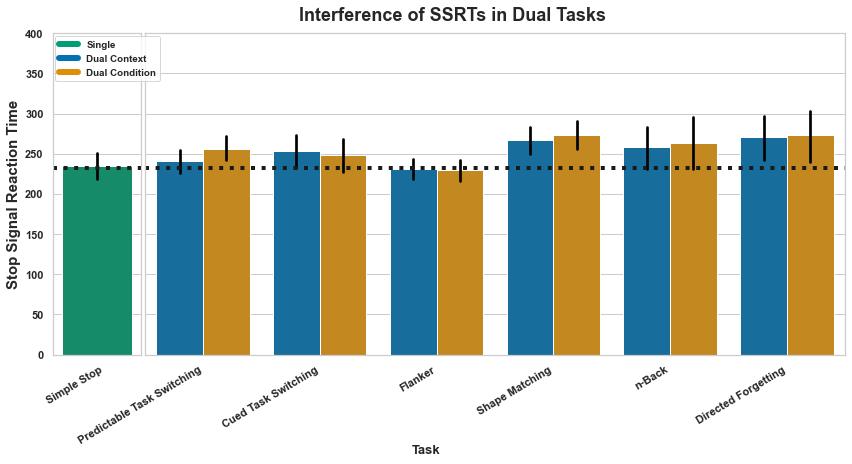

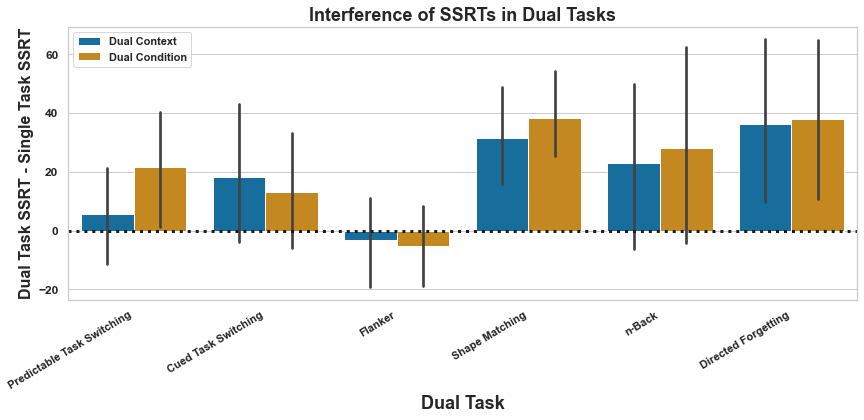

In [25]:
thresh_SSD_tests = pipeline(SSRTs_ThreshSSDs, strip_str='_wThresh_SSDs')

In [26]:
thresh_SSD_tests.to_csv(f'result_csvs/dataset-{dataset}_metric-SSRT_wThresh_SSDs_tests-validationContrasts.csv')

# Exclude Short SSD subjects

22 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,59893.475178,6,9982.245863,9.292882,3.381992e-07,0.000141,0.481674,0.514028,False,0.008501,0.016836
1,Error,64450.915355,60,1074.181923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


directed_forgetting: Mean=34.85, t=6.170, p=0.000000, d=1.79
n_back: Mean=34.85, t=1.974, p=0.026519, d=0.50
cued_task_switching: Mean=34.85, t=0.319, p=0.375513, d=0.09
shape_matching: Mean=34.85, t=2.071, p=0.021345, d=1.35
n-Back DE > DC: Mean=29.86, t=1.124, p=0.143609, d=0.36


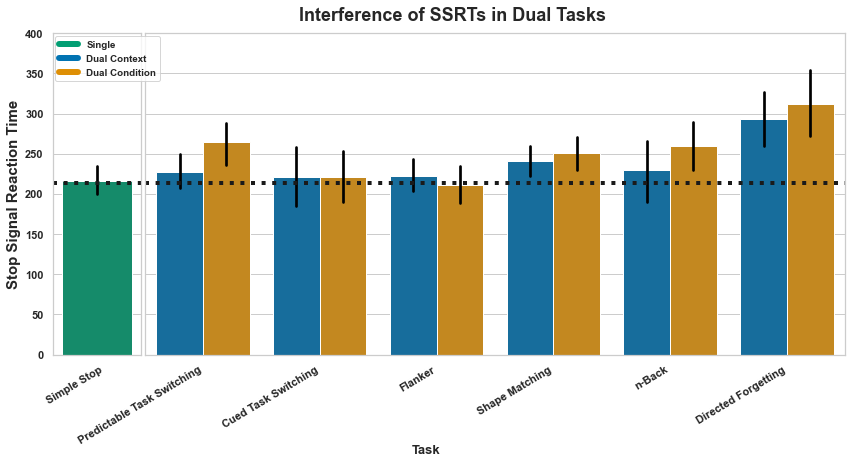

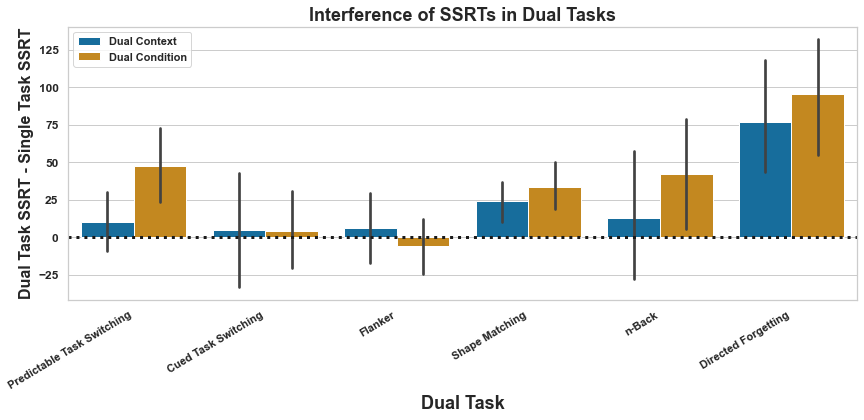

In [27]:
thresh_subs_tests = pipeline(SSRTs_ThreshSubs, strip_str='_wThresh_subs')

In [28]:
thresh_subs_tests.to_csv(f'result_csvs/dataset-{dataset}_metric-SSRT_wThresh_subs_tests-validationContrasts.csv')